# City street network orientations

Compare the spatial orientations of city street networks.

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd

ox.config(log_console=True, use_cache=True)
weight_by_length = False

In [21]:
# define the study sites as label : query
places = {'Boston' : 'Boston, MA, USA'} 

In [22]:
# verify OSMnx geocodes each query to what you expect
gdf = ox.gdf_from_places(places.values())
gdf

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,-70.804488,42.396977,42.227654,-71.19126,"POLYGON ((-71.19126 42.2828375, -71.1910708000...","Boston, Suffolk County, Massachusetts, United ..."


## Get the street networks and their edge bearings

In [23]:
bearings = {}
for place in sorted(places.keys()):
    
    # get the graph
    query = places[place]
    G = ox.graph_from_place(query, network_type='drive')
    
    # calculate edge bearings
    G = ox.add_edge_bearings(G)
    
    if weight_by_length:
        # weight bearings by length (meters)
        streets = [(d['bearing'], int(d['length'])) for u, v, k, d in G.edges(keys=True, data=True)]
        city_bearings = []
        for street in streets:
            city_bearings.extend([street[0]] * street[1])
        bearings[place] = pd.Series(city_bearings)
    else:
        # don't weight bearings, just take one value per street segment
        bearings[place] = pd.Series([data['bearing'] for u, v, k, data in G.edges(keys=True, data=True)])

## Visualize it

In [24]:
# function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=36, title=''):

    bins = [ang * 360 / n for ang in range(0, n + 1)]
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'Century Gothic', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'Century Gothic', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'Century Gothic', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

In [25]:
def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # this prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = [ang * 360 / n for ang in range(0, n + 1)]
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = count.tolist()
    count = [count[-1]] + count[:-1]

    count_merged = []
    count_iter = iter(count)
    for count in count_iter:
        merged_count = count + next(count_iter)
        count_merged.append(merged_count)

    return np.array(count_merged)

TypeError: 'PolarAxesSubplot' object is not iterable

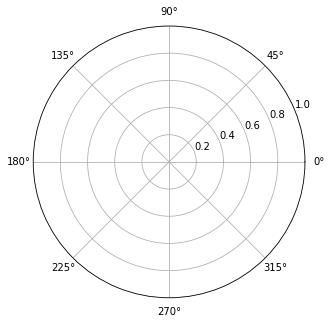

In [26]:
# create figure and axes
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})
axes = [item for sublist in axes for item in sublist]

# plot each city's polar histogram
for ax, place in zip(axes, sorted(places.keys())):
    polar_plot(ax, bearings[place], title=place)

# add super title and save full image
suptitle_font = {'family':'Century Gothic', 'fontsize':60, 'fontweight':'normal', 'y':1.07}
fig.suptitle('City Street Network Orientation', **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
plt.gcf().savefig('images/street-orientations.png', dpi=120, bbox_inches='tight')
plt.close()